<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#constants
COUNT = 200
MONEY = 10**10
REVENUE = 45*(10**4)
STATE = np.random.RandomState(12345)

In [3]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

В каждой таблице 100000 строк и 5 колонок, тип данных: id - object, остальные колонки - float64

In [4]:
#Функция информации о таблицах
def check(df):
    dup_list = []
    print('Первые пять строк: \n', df.head())
    print('########################')
    print('Информация о талице: \n', df.info())
    print('########################')
    print('Количество пропусков в таблице: \n', df.isna().sum())
    print('########################')
    print('Количество дупликатов в таблице: \n', df.duplicated().sum())
    print('########################')
    for i in df[df['id'].duplicated()]['id']:
        if i not in dup_list:
            dup_list.append(i)
    print('Поиск неявных дупликатов: \n', df[df['id'].duplicated()]['id'].values)
    print('########################')
    print('Графики')
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1) 
    plt.title('Ящик с усами')
    
    plt.ylabel('Объём')
    plt.boxplot (x = df['product'])
    plt.subplot(1, 2, 2)
    plt.title('Гистограмма распределения объёма')
    plt.xlabel('Объём')
    plt.ylabel('Количество')
    plt.hist(x = df['product'], bins=35, range = (0, 200))
    plt.show()
    return dup_list

Первые пять строк: 
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Информация о талице: 
 None
########################
Количество пропусков в таблице: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
########################
Количество дупликатов в 

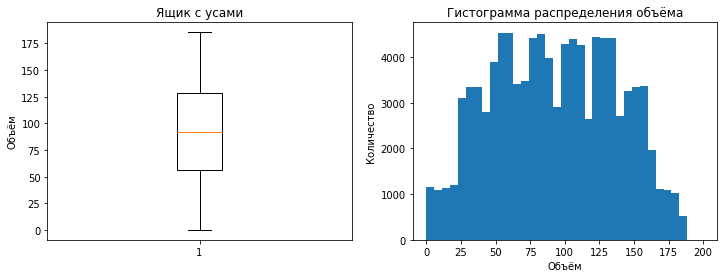

In [5]:
dup_1 = check(df1)

Первые пять строк: 
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Информация о талице: 
 None
########################
Количество пропусков в таблице: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
########################
Количество д

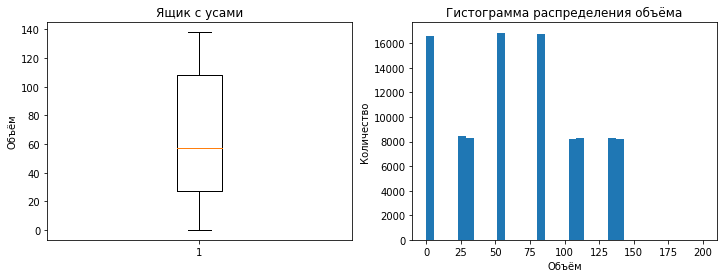

In [6]:
dup_2 = check(df2)

Первые пять строк: 
       id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Информация о талице: 
 None
########################
Количество пропусков в таблице: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
########################
Количество дупликатов в 

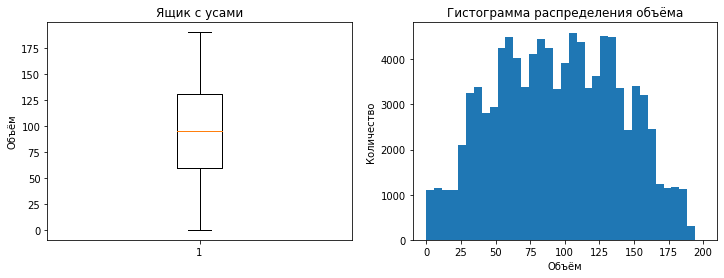

In [7]:
dup_3 = check(df3)

### Вывод

Пропусков нет, явных дупликатов нет, есть дупликаты в столбце id, но неизвестно, какой именно нужно убрать. Из графика распределения объёма по второй таблице видно, что много пустых скважин и много заполненных скважин, скорее всего, добыча там больше не осуществляется

## Обучение и проверка модели

В данных отсутсвуют пропуски. Удалим из каждого датафрейма столбец id. Он не несет значимости для для модели

In [8]:
data1 = df1.drop(['id'], axis=1)
data2 = df2.drop(['id'], axis=1)
data3 = df3.drop(['id'], axis=1)

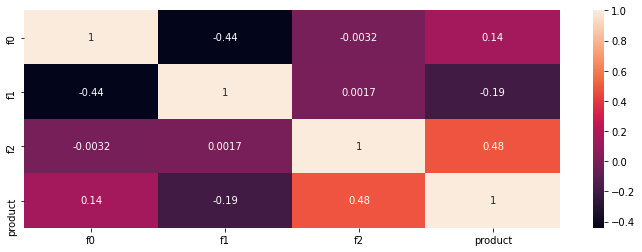

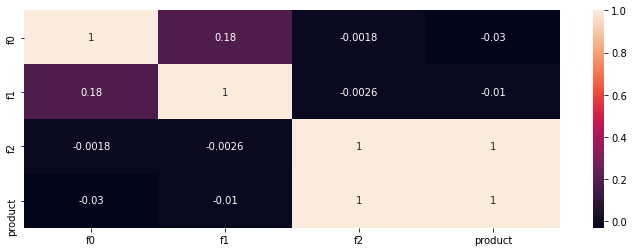

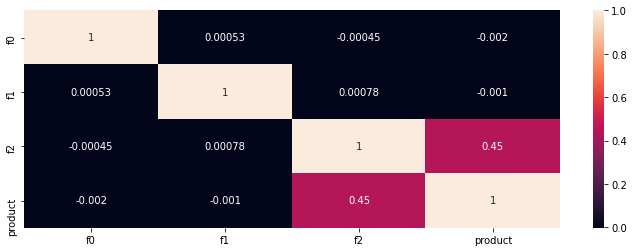

In [9]:
#Карта корреляций
for i in [df1,df2,df3]:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 1, 1) 
    sns.heatmap(i.corr(), annot = True);

In [10]:
#Функция берет на вход датасет.Оставляет только нужные признаки,Делит df на train и test, шкалирует, обучает линейную модель,
#Возвращает tuple с предсказаниями, labelы, RMSE
def split_and_train(data):
 
    features = data.drop("product", axis=1)
    target = data["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product: {0:.2f}".format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse, average_product)

In [11]:
predictions_1, target_1, rmse_1, avg_1 = split_and_train(data1)
predictions_2, target_2, rmse_2, avg_2 = split_and_train(data2)
predictions_3, target_3, rmse_3, avg_3 = split_and_train(data3)

RMSE: 37.58
Average product: 92.59
RMSE: 0.89
Average product: 68.73
RMSE: 40.03
Average product: 94.97


### Вывод

В третьем регионе средний запас сырья и RMSE выше, чем в остальных. С точки зрения ошибки прогноза привлекательнее второй регион

## Подготовка к расчёту прибыли

In [12]:
volume = MONEY/COUNT/REVENUE
print('Достаточный объём для безубыточной разработки новой скважины:', volume)

Достаточный объём для безубыточной разработки новой скважины: 111.11111111111111


### Вывод

Средний объём скважен в регионах меньше, чем достаточный объём для безубыточности

## Расчёт прибыли и рисков 

In [13]:
#функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def revenue(target, probabilities, count):
    # Выберите скважины с максимальными значениями предсказаний.
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return REVENUE * selected.sum() - MONEY

In [14]:
region = ['Первый регион', 'Второй регион', 'Третий регион']
def riskfunc(tgt, pred, num):
    values = []
    for j in range(1000):
        target_subsample = tgt.sample(n = 500, replace = True, random_state = STATE)
        probs_subsample = pred.loc[target_subsample.index]

        values.append(revenue(target_subsample, probs_subsample, COUNT))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = values[values < 0].count()/values.count()*100
    mean = values.mean()
    print(region[num])
    print("Средняя выручка:", round(mean/10**6, 2), 'млн.руб')
    print("Доверительный интервал от:", round(lower/10**6, 2),'млн.руб.', 'до:', round(upper/10**6, 2),'млн.руб')
    print("Риск:", round(risk, 2), '%')

In [15]:
riskfunc(target_1, predictions_1, 0)

Первый регион
Средняя выручка: 425.94 млн.руб
Доверительный интервал от: -102.09 млн.руб. до: 947.98 млн.руб
Риск: 6.0 %


In [16]:
riskfunc(target_2, predictions_2, 1)

Второй регион
Средняя выручка: 518.26 млн.руб
Доверительный интервал от: 128.12 млн.руб. до: 953.61 млн.руб
Риск: 0.3 %


In [17]:
riskfunc(target_3, predictions_3, 2)

Третий регион
Средняя выручка: 420.19 млн.руб
Доверительный интервал от: -115.85 млн.руб. до: 989.63 млн.руб
Риск: 6.2 %


### Вывод

- Самая высокая средняя выручка во втором регионе
- Самый низкий процент риска во втором регионе
- Самый низкий риск убытка у второго региона - 0.3%
- Самый высокий риск, самый большой интервал, самая низкая средняя выручка в третьем регионе

## Вывод

- В третьем регионе средний запас сырья и RMSE выше, чем в остальных
- С точки зрения ошибки прогноза привлекательнее второй регион
- Средний прогнозируемый объём скважен в регионах меньше, чем достаточный объём для безубыточности
- Самая высокая средняя выручка во втором регионе
- Самый низкий риск убытка у второго региона - 0.3%
- Самый высокий риск, самый большой интервал, самая низкая средняя выручка в третьем регионе
- Регион для разработки месторождения - второй регион